# Conversion Rate: A/B testing
This is a solution to a problem about A/B testing from the must have book on interview prep(A collection of Data Science Interviews). 

Goal: Predict conversion rate

In [1]:

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pylab as pl
import statsmodels.api as sm
import sklearn as sk
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from patsy import dmatrices
from sklearn.cross_validation import cross_val_score
from sklearn import svm
from sklearn.linear_model import SGDClassifier

plt.style.use('fivethirtyeight') #plot style used by fivethirtyeight
mpl.rcParams['figure.figsize'] = (12.0, 7.0)

In [2]:
data= pd.read_csv(".../ecommerce.csv") 

Let's take a quick glance at the data 

In [3]:
data.head(3) #observe the first three rows of the data

,country,age,new_user,source,total_pages_visited,converted
0,UK,20,1,Direct,11,1
1,UK,37,1,Ads,15,1
2,UK,30,0,Seo,15,1


The dataset contains information on 
1. country of a visitor
2. age
3. whether or not the visitor is new to the website
4. how the visitor came to find out about the website and the total pages visited. 
5. The target variable is whether or not the visitor converted(purchased something)

In [4]:
print "The shape of the data is:", data.shape

The shape of the data is: (20400, 6)


We have 20,400 rows and 6 columns. Next, I would like to observe some summary statistics

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20400 entries, 0 to 20399
Data columns (total 6 columns):
country                20400 non-null object
age                    20400 non-null int64
new_user               20400 non-null int64
source                 20400 non-null object
total_pages_visited    20400 non-null int64
converted              20400 non-null int64
dtypes: int64(4), object(2)
memory usage: 956.3+ KB


In [6]:
data.describe()

,age,new_user,total_pages_visited,converted
count,20400.000000,20400.000000,20400.000000,20400.000000
mean,28.534804,0.499510,9.551569,0.500000
std,7.923346,0.500012,6.062382,0.500012
min,17.000000,0.000000,1.000000,0.000000
25%,22.000000,0.000000,4.000000,0.000000
50%,27.000000,0.000000,9.000000,0.500000
75%,34.000000,1.000000,15.000000,1.000000
max,123.000000,1.000000,30.000000,1.000000


Looking at the summary statistics, there is no missing data as all the variables have the same exact count. Something stands out immediately in the age statistic. The oldest visitor is 123. It seems to me that this is unlikely. Let's further investigate

In [7]:
 np.sort(data['age'].unique()) #check for unique ages and sort

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  65,  71, 111, 123])

We notice that we have two ages that are over 100 (111 and 123 to be exact). These may be errors, so I plan on dropping them from the sample. But first, I want to check how many values we have over 100.

In [8]:
len(data[data.age>100])

2

Now we know that we only have two occurences of the 20,400 observations that are over 100. Now I feel much better about dropping those rows. 

An interesting question is why do we have those ages? While it is not impossible to have customers that age, it is probably very unlikely. This could be a result of a problem with the website or customers putting bogus ages for whatever reason, accidental or on purpose.

In [9]:
df=data[data.age<100] # Only consider the ages less than 100

## Exploratory Data Analysis
Before using any model, we can take a much closer look at the data to see what is going on.

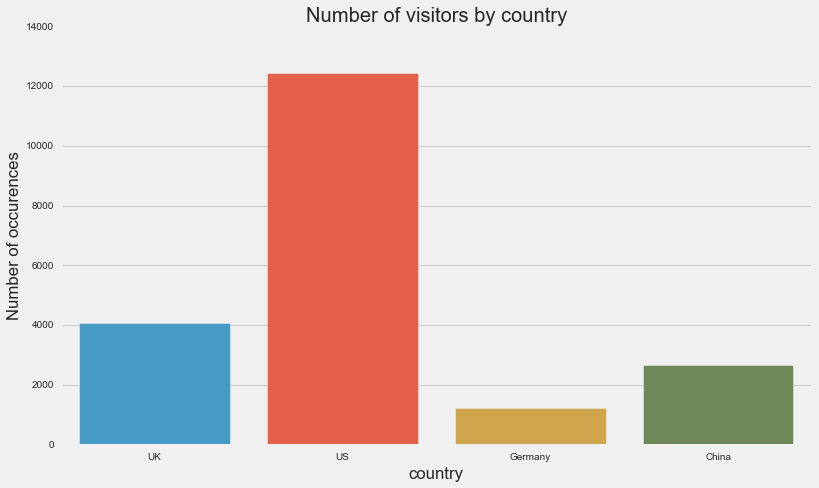

In [10]:
sns.countplot(df.country)
plt.ylabel('Number of occurences')
plt.title('Number of visitors by country')

The overwhelming bulk of visitors originate from the United States. This is likely because this is an American website

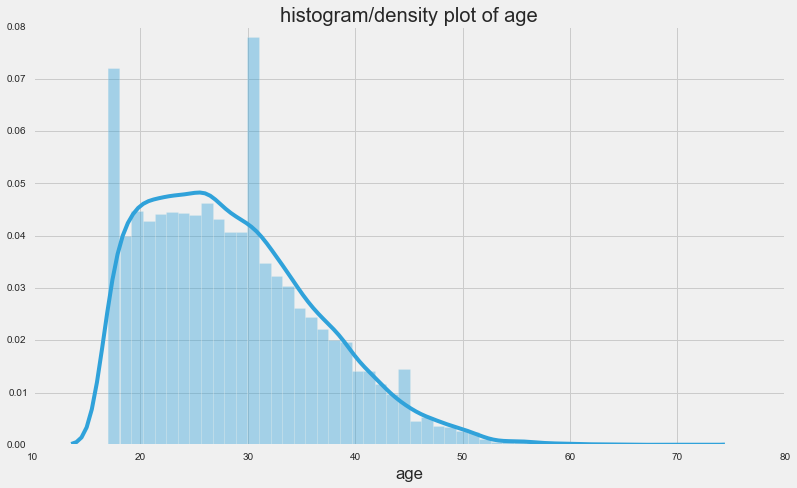

In [11]:
sns.distplot(df.age)
plt.title('histogram/density plot of age')

A bulk of the visitors are somewhere between the ages of 18 and 40. The distribution is skewed to the right with a few older visitors.

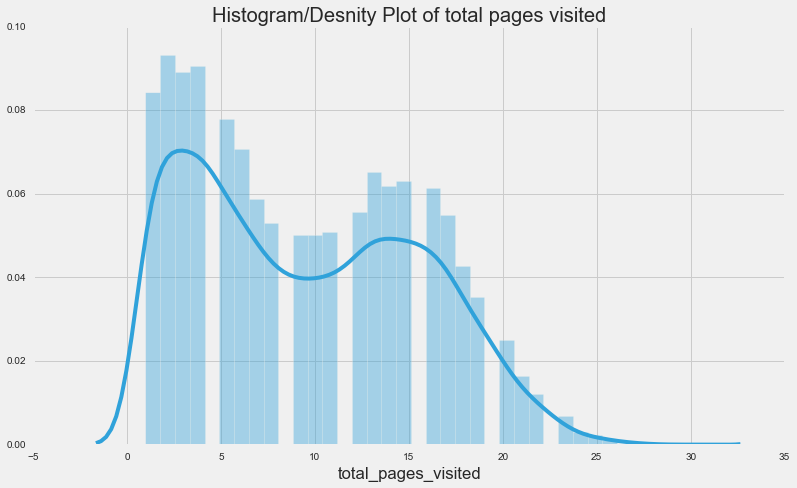

In [12]:
sns.distplot(df.total_pages_visited)
plt.title('Histogram/Desnity Plot of total pages visited')

The total pages visited appears to have a bimodial distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ba4abd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10bbc0d90>]], dtype=object)

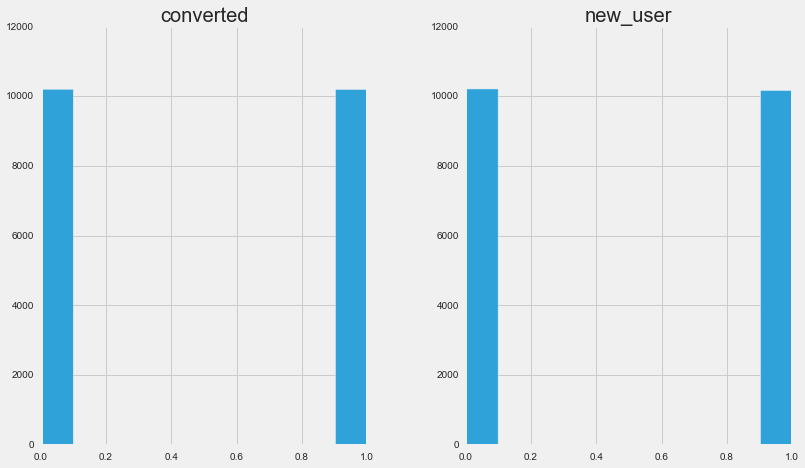

In [13]:
df[['new_user','converted']].hist()

new_user and converted are categorical variables that are finely balanced i.e. equal split between 0 and 1.

### Let's look at is the conversion rate per country and age group

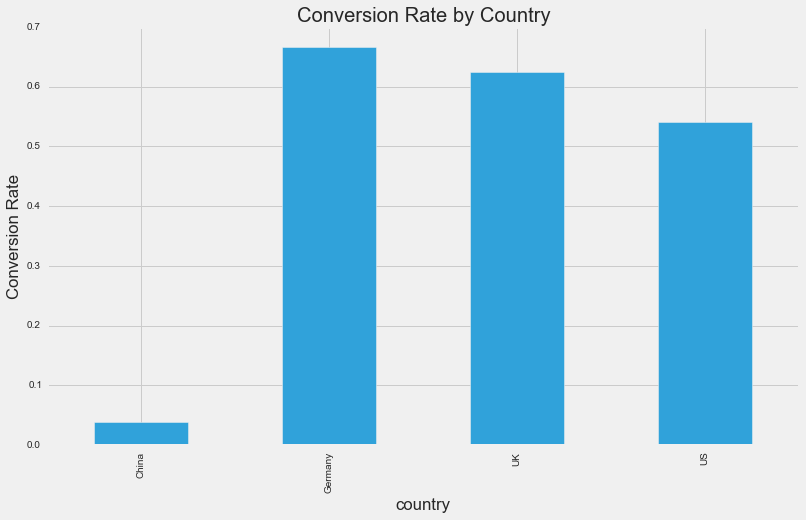

In [14]:
conversion_bycountry=df.groupby('country')
#conversion_bycountry.describe() #descriptive stats for the conversion rate per country

conversion_bycountry['converted'].mean().plot(kind='bar')
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate by Country')

China has a remarkably low conversion rate while Germany has the best. This may indicate that there's a problem with the chinese website or that the product being sold is not highly valued or properly marketed in China. 

### Conversion rate by total pages visited

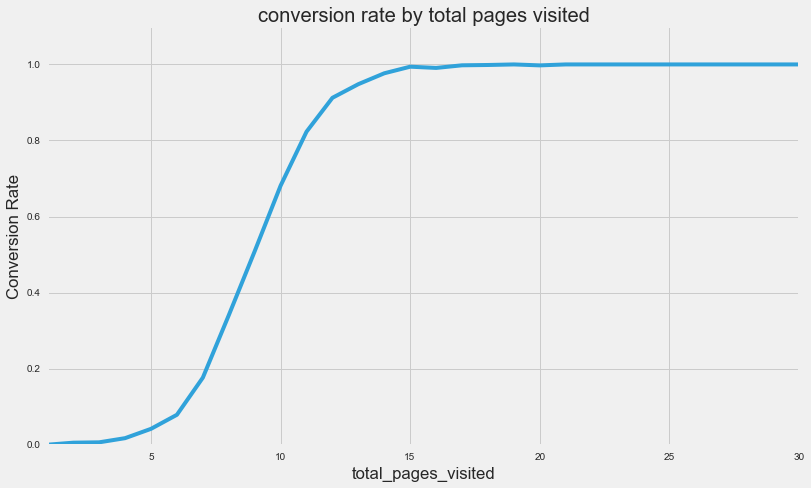

In [15]:
df.groupby('total_pages_visited')['converted'].mean().plot()
plt.ylim(0,1.1)
plt.ylabel('Conversion Rate')
plt.title('conversion rate by total pages visited')

On average, it appears that the more pages a visitor clicks on, the higher the chance of the visitor converting. Why is this so? What type of actions can a company take to ensure increase in pages visited? 
One possibility may be that the very nature of clicking through to buy something involves going through multiple pages. 

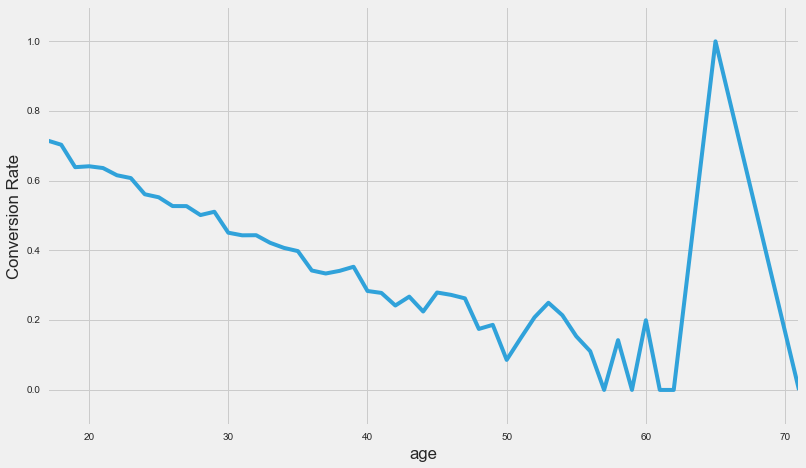

In [16]:
df.groupby('age')['converted'].mean().plot()
plt.ylim(-0.1,1.1)
plt.ylabel('Conversion Rate')

Younger people are more likely to convert than older people. We see that the conversion rate seems to drop almost linearly and then we see a spike from between 60 and 70 years. Let's investigate further

In [17]:
df[df.age>60].sort_values('age')

,country,age,new_user,source,total_pages_visited,converted
16674,US,61,0,Ads,1,0
18813,US,61,1,Seo,9,0
20197,US,62,1,Direct,4,0
748,UK,63,0,Seo,20,1
14214,US,63,0,Seo,1,0
18087,UK,63,0,Seo,2,0
357,UK,65,0,Ads,15,1
15968,China,71,1,Ads,3,0


We can confirm that the spike at age 65 is due to the fact that we only have one customer in that age group. As we guessed, that customer happened to convert.

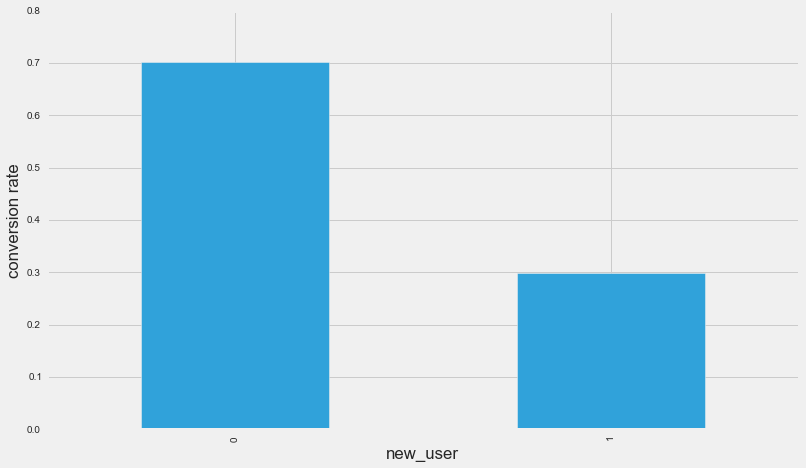

In [18]:
df.groupby('new_user')['converted'].mean().plot(kind='bar')
plt.ylabel('conversion rate')

Old users on average have a higher conversion rate than new users. 

### Some more interesting plots
1. The difference in age distribution for customers who converted and those who did not

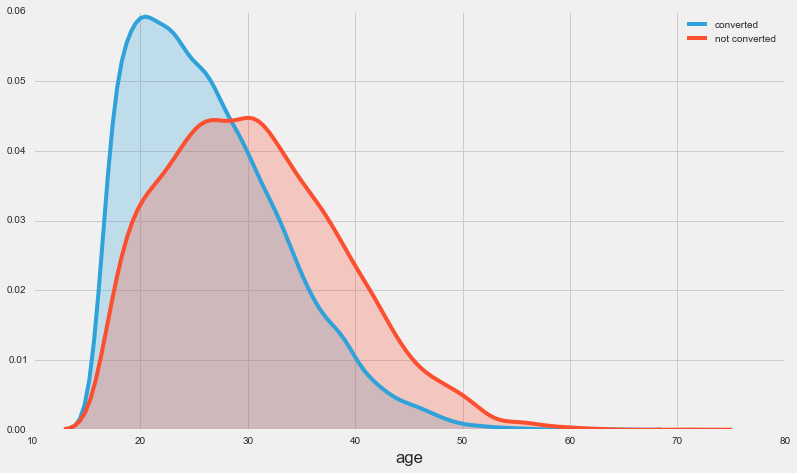

In [21]:
sns.kdeplot(df[df.converted==1].age,shade=True, label='converted')
sns.kdeplot(df[df.converted==0].age,shade=True, label='not converted')
plt.xlabel('age')

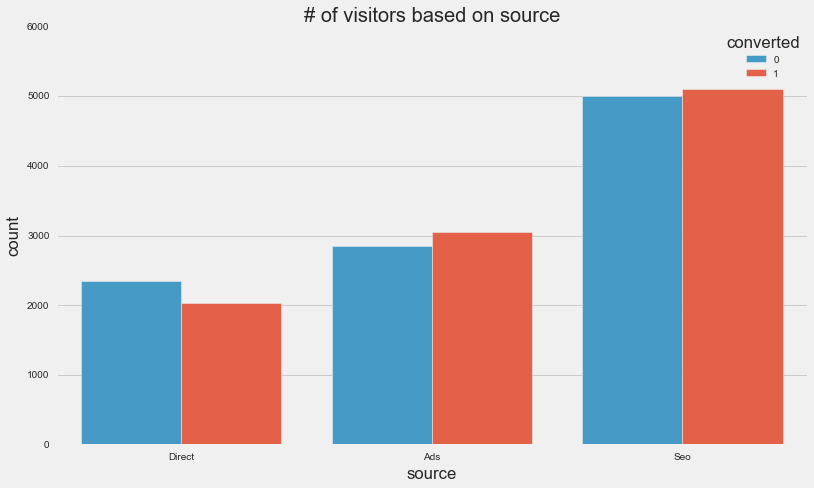

In [22]:
sns.countplot(df.source,hue=df.converted)
plt.title('# of visitors based on source')

In [24]:
df['age_range'] = pd.cut(df['age'], [0, 20, 40, 60, 80, 100])


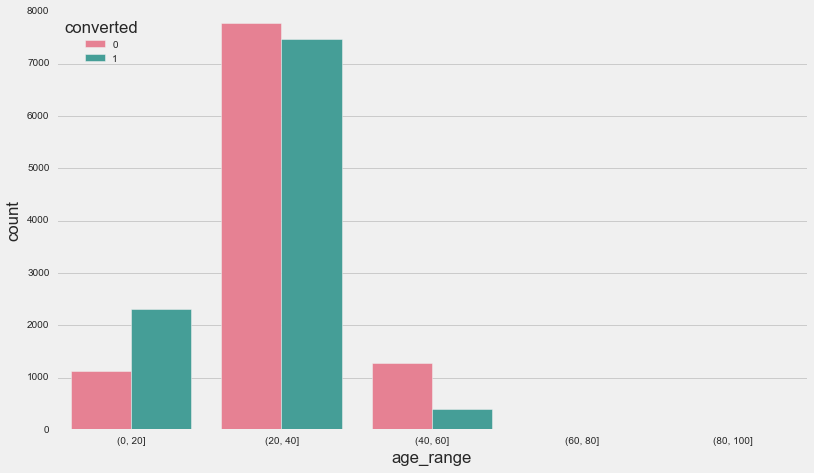

In [25]:
sns.countplot(df.age_range,hue=df.converted,palette="husl")

## Summary of basic data insights
1. The website is likely american as we can see lots of americans using it.
2. The website is doing really poorly in China as seen by the really low conversion rate
3. Most of the visitors are relatively young and they tend to convert more than the older visitors
4. Most of the visitors get to the website through Search engine optimization. 
5. Old users tend to convert more than first time users


In [23]:
#df=df.reset_index()
#del df['index']

# Classification Model
### Logistic Regression

In [26]:
data_country=pd.get_dummies(df['country'])
data_source=pd.get_dummies(df['source'])
data_age_range=pd.get_dummies(df['age_range'])
df=pd.concat([df,data_country,data_source,data_age_range], axis=1)


In [28]:
df.head(3)

,country,age,new_user,source,total_pages_visited,converted,age_range,China,Germany,UK,US,Ads,Direct,Seo,"(0, 20]","(20, 40]","(40, 60]","(60, 80]","(80, 100]"
0,UK,20,1,Direct,11,1,"(0, 20]",0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,UK,37,1,Ads,15,1,"(20, 40]",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,UK,30,0,Seo,15,1,"(20, 40]",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


# use logistic regression

In [29]:
X=df[['age', 'new_user','total_pages_visited', 'US', 'Seo','Ads']] #avoid dummy variable trap
y=df['converted']

In [30]:
#split the data into train and test with a 75/25 split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, random_state=33)


# Train and evaluate using k-CV
1. fit model 
2. cross-validaate

In [31]:
def evaluate_CV(classifier,X_train,y_train):
    classifier.fit(X_train,y_train)
    print 'Coefficient of determination of training set', classifier.score(X_train,y_train)
    #print classifier.fit(X_train,y_train).get_params()
    print 'coefficient of model:', classifier.coef_
    cv = KFold(X_train.shape[0],5, shuffle=True,random_state=33)
    scores = cross_val_score(classifier, X_train, y_train, cv=cv)
    print "The cv scores are:", scores
    print "Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores)


In [311]:
def test(classifier,X_test,y_test):
    print classifier.score(X_test,y_test)

In [32]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [33]:
#logistic regression
log_model=LogisticRegression()
evaluate_CV(log_model,X_train,y_train)

Coefficient of determination of training set 0.934566610014
coefficient of model: [[-0.54810096 -0.87409532  4.6422622   0.16945691  0.134648    0.15729924]]
The cv scores are: [ 0.93366013  0.93954248  0.93529412  0.93396535  0.93102321]
Average coefficient of determination using 5-fold crossvalidation: 0.934697058076


In [46]:
#train and evaluate
def train_evaluate(classifier,X_train,y_train,X_test,y_test):
    classifier.fit(X_train,y_train)
    y_pred=classifier.predict(X_test)
    #print "score for model is",classifier.score(X_test,y_test)
    print "Test Error Rate:", 1-np.mean(y_test==y_pred)
    print metrics.classification_report(y_test, y_pred)

In [47]:
train_evaluate(log_model,X_train,y_train,X_test,y_test)

Test Error Rate: 0.0650980392157
             precision    recall  f1-score   support

          0       0.93      0.94      0.94      2544
          1       0.94      0.93      0.93      2556

avg / total       0.93      0.93      0.93      5100



## Let's see how other models will train and the test error rate

In [348]:
heldout_portion = [0.95, 0.90, 0.75, 0.50, 0.01]
rounds = 20

In [349]:
classifiers=[("log_model",LogisticRegression()),
            ("svm", svm.SVC()),
            ("SGDC", SGDClassifier())]

training log_model
training svm
training SGDC


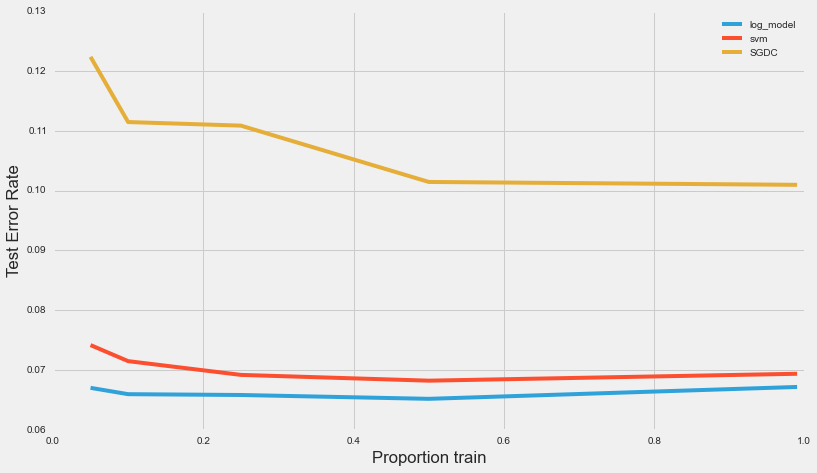

In [350]:
xx = 1. - np.array(heldout_portion)

for name, clf in classifiers:
    print("training %s" % name)
    rng = np.random.RandomState(42)
    yy = []
    for i in heldout:
        test_error = []
        for r in range(rounds):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=rng)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            test_error.append(1 - np.mean(y_pred == y_test))
        yy.append(np.mean(test_error))
    plt.plot(xx, yy, label=name)

plt.legend(loc="upper right")
plt.xlabel("Proportion train")
plt.ylabel("Test Error Rate")
plt.show()

Log model has the lowest test error rate. This is a basic solution as of yet. More time spent in feature engineering may improve the model or more flexible methods such as forests may be needed